In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import numpy as np

import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

import statsmodels.api as sm

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import scale

(138, 10) (117, 10) (21, 10)


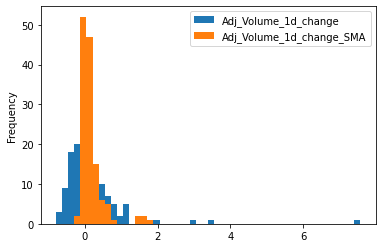

In [47]:
ticker = 'ACHR'
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*5)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download(
    ticker, 
    start=start_date, 
    end=end_date, 
    progress=False
)

lng_df = data[['Adj Close', 'Volume']].reset_index()
lng_df.rename(columns={'Adj Close': 'Adj_Close', 'Volume':'Adj_Volume'}, inplace=True)

# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
lng_df = lng_df.dropna()

lng_df['Adj_Volume_1d_change_SMA'] = talib.SMA(lng_df['Adj_Volume_1d_change'].values, timeperiod=5)

# Plot histogram of volume % change data
lng_df[new_features].plot(kind='hist', sharex=False, bins=50)

lng_df.set_index('Date', inplace=True)
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(
    lng_df.index.dayofweek,
    prefix='weekday',
    drop_first=True
)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

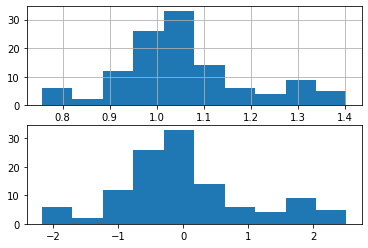

In [48]:
# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

Epoch 1/25
4/4 [==============================] - 1s 2ms/step - loss: 0.0895
Epoch 2/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0389
Epoch 3/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 4/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0194
Epoch 5/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 6/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 7/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 8/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0081
Epoch 9/25
4/4 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 10/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0065
Epoch 11/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 12/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 13/25
4/4 [==============================] - 0s 4ms/step - loss: 0.

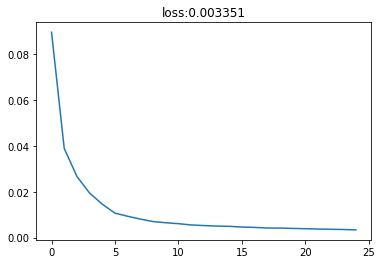

In [49]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.8180783375720017
-0.6340502527565941


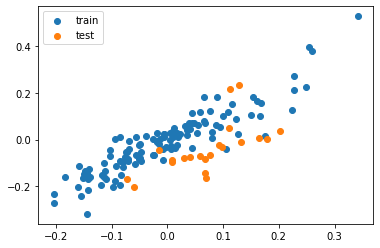

In [50]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

Epoch 1/25
4/4 [==============================] - 1s 4ms/step - loss: 6.1217
Epoch 2/25
4/4 [==============================] - 0s 5ms/step - loss: 2.4042
Epoch 3/25
4/4 [==============================] - 0s 7ms/step - loss: 1.2686
Epoch 4/25
4/4 [==============================] - 0s 5ms/step - loss: 0.7513
Epoch 5/25
4/4 [==============================] - 0s 5ms/step - loss: 0.6395
Epoch 6/25
4/4 [==============================] - 0s 4ms/step - loss: 0.3677
Epoch 7/25
4/4 [==============================] - 0s 4ms/step - loss: 0.2923
Epoch 8/25
4/4 [==============================] - 0s 6ms/step - loss: 0.1711
Epoch 9/25
4/4 [==============================] - 0s 4ms/step - loss: 0.1450
Epoch 10/25
4/4 [==============================] - 0s 5ms/step - loss: 0.2514
Epoch 11/25
4/4 [==============================] - 0s 5ms/step - loss: 0.1796
Epoch 12/25
4/4 [==============================] - 0s 4ms/step - loss: 0.1397
Epoch 13/25
4/4 [==============================] - 0s 5ms/step - loss: 0.

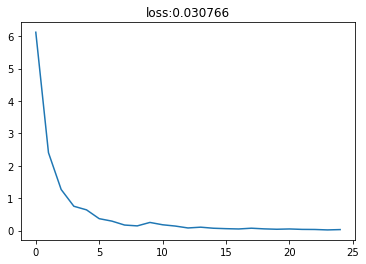

In [51]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras

# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.3659711069683833
-0.16828122007456892


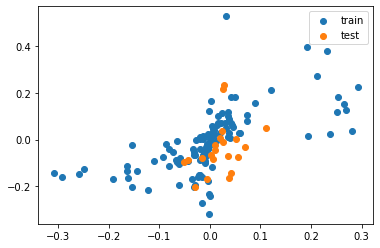

In [52]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

Epoch 1/25
4/4 [==============================] - 1s 6ms/step - loss: 0.1122
Epoch 2/25
4/4 [==============================] - 0s 9ms/step - loss: 0.0644
Epoch 3/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 4/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 5/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0303
Epoch 6/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0287
Epoch 7/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 8/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0177
Epoch 9/25
4/4 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 10/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 11/25
4/4 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 12/25
4/4 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 13/25
4/4 [==============================] - 0s 6ms/step - loss: 0.

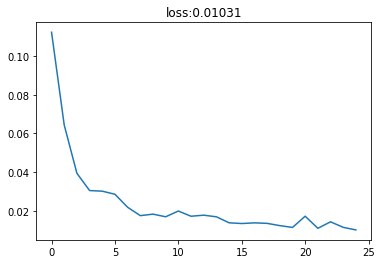

In [53]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

[ 0.02419862 -0.00716095 -0.02635898  0.01898162  0.02269541]
0.6680867247778712
-0.09174598403268841


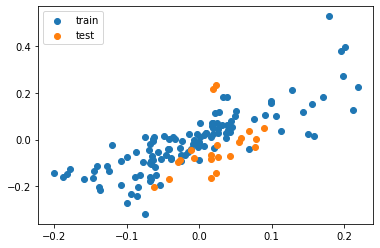

In [54]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()